<a href="https://colab.research.google.com/github/Pentuhov/PR-AI7/blob/main/%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9_%D0%94%D0%97_Lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В задании используется база курса акций Лукойла.

1. Обучите простую полносвязную сеть для прогнозирования временного ряда (только close) и визуализируйте результат.

2. Обучите такую же архитектуру сети на прогнозирование на 10 шагов вперёд прямым способом и визуализируйте результат.

3. Постройте графики сравнения предсказания с оригинальным сигналом по всем 10 шагам предсказания (10 графиков на разных отдельных осях).

4. Сделайте те же задания с другой сетью, которая будет использовать Conv1D или LSTM слои.


## Подготовка данных

Загрузка библиотек

In [1]:
import os
import random
import numpy as np
import tensorflow as tf

def seed_everything(seed=22312):
    random.seed(seed)  # Seed для встроенного модуля random Python
    np.random.seed(seed)  # Seed для numpy
    tf.random.set_seed(seed)  # Seed для TensorFlow
    os.environ['PYTHONHASHSEED'] = str(seed)  # Устанавливает seed для операций на основе хэшей в Python

# Вызов функции для установки seed
seed_everything()

In [2]:
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

# Отрисовка графики в ячейке colab
%matplotlib inline

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Назначение размера и стиля графиков по умолчанию
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

Загрузка базы

In [4]:
# Загрузка датасетов из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/16_17.csv', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/18_19.csv', None, quiet=True)

'18_19.csv'

In [5]:
# Чтение данных в таблицу pandas
base_data = pd.read_csv('18_19.csv', sep=';')

In [6]:
# Вывод первых строк таблицы
base_data.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,03.01.2018,10:00:00,3341.0,3356.0,3340.0,3355.0,6088
1,03.01.2018,10:01:00,3355.0,3359.0,3353.0,3353.0,1624
2,03.01.2018,10:02:00,3351.5,3357.5,3351.5,3357.5,722
3,03.01.2018,10:03:00,3354.5,3360.0,3354.5,3358.0,3034
4,03.01.2018,10:04:00,3358.0,3360.0,3351.5,3360.0,1427


In [7]:
# Загрузка датасетов с удалением ненужных столбцов по дате и времени

data16_17 = pd.read_csv('16_17.csv', sep=';').drop(columns=['DATE', 'TIME'])
data18_19 = pd.read_csv('18_19.csv', sep=';').drop(columns=['DATE', 'TIME'])

In [8]:
# Просмотр размерностей получившихся табли

print(data16_17.shape)
print(data18_19.shape)

(263925, 5)
(217947, 5)


In [9]:
# Пример данных одного датасета
d = data18_19

print(d.shape[0])  # Всего записей (строк)
print(d.shape[1])  # Количество столбцов
print(d.iloc[0])   # Пример нулевой строки данных

217947
5
OPEN      3341.0
MAX       3356.0
MIN       3340.0
CLOSE     3355.0
VOLUME    6088.0
Name: 0, dtype: float64


In [10]:
# Создание общего набора данных из двух датасетов

data = pd.concat([data16_17, data18_19]).to_numpy()

In [11]:
# Просмотр размерности новой таблицы

print(data16_17.shape)
print(data18_19.shape)
print(data.shape)

(263925, 5)
(217947, 5)
(481872, 5)


In [12]:
# Задание текстовых меток каналов данных (столбцов)

channel_names = ['Open', 'Max', 'Min', 'Close', 'Volume']

Иллюстрация данных в графическом виде

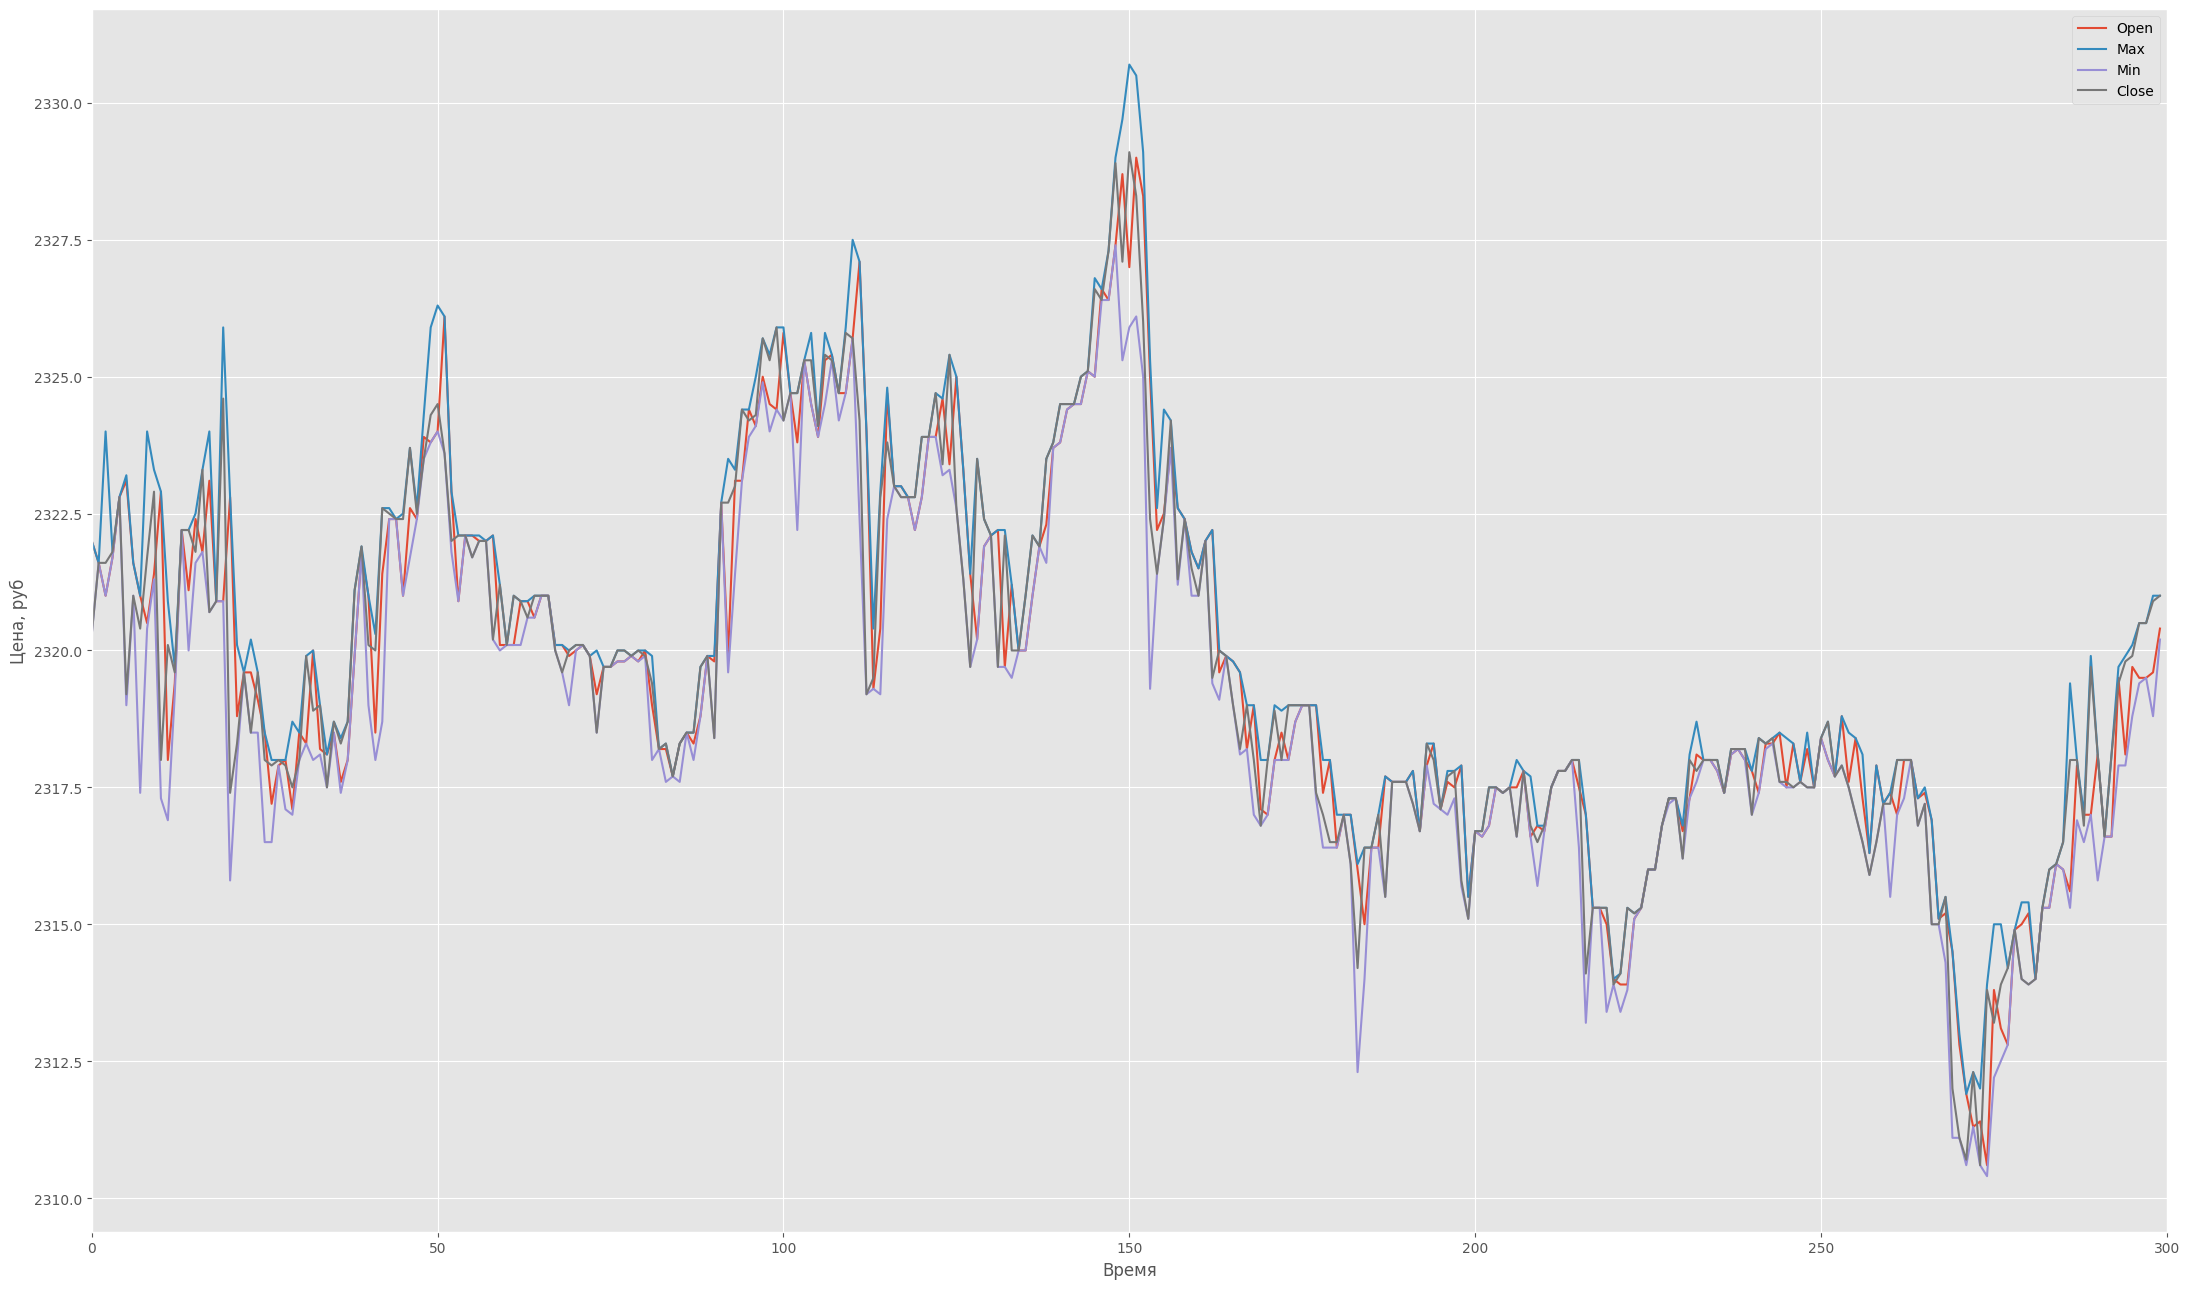

In [13]:
# Отображение исходных данных от точки start и длинной length
start = 100
length = 300

# Задание полотна для графиков - два подграфика один под другим с общей осью x
fig, ax = plt.subplots(figsize=(22, 13), sharex=True)

# Четыре основных канала - open, max, min, close
for chn in range(4):
    # Отрисовка одного канала данных
    # От начальной точки start длиной length
    ax.plot(data[start:start + length, chn],
             label=channel_names[chn])
ax.set_ylabel('Цена, руб')
ax.legend()
plt.xlabel('Время')

# Регулировка пределов оси x
plt.xlim(0, length)

# Указание расположить подграфики плотнее друг к другу
plt.tight_layout()

# Фиксация графика
plt.show()

Полносвязная сеть для прогнозирования на 1 шаг вперед

Подготовка данных

In [14]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Загрузка данных
data = pd.read_csv('18_19.csv', sep=';')

# Извлекаем только числовые столбцы (например, исключаем столбцы с датами и временем)
numeric_features = ['OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME']
data_numeric = data[numeric_features].values

# Параметры загрузки данных
xLen = 300      # Анализируем по 300 прошедшим точкам
valLen = 30000  # Используем 30.000 записей для проверки
batch_size = 20 # Размер batch
target = 3      # Индекс столбца 'CLOSE' в numeric_features
trainLen = data_numeric.shape[0] - valLen # Размер тренировочной выборки

# Делим данные на тренировочную и тестовую выборки
xTrain, xTest = data_numeric[:trainLen], data_numeric[trainLen + xLen + 2:]
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

# Масштабируем Y
yTrain, yTest = np.reshape(data_numeric[:trainLen, target], (-1, 1)), np.reshape(data_numeric[trainLen + xLen + 2:, target], (-1, 1))
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

# Создаем генератор для обучения и тестирования
trainDataGen = TimeseriesGenerator(xTrain, yTrain, length=xLen, stride=1, batch_size=batch_size)
testDataGen = TimeseriesGenerator(xTest, yTest, length=xLen, stride=1, batch_size=batch_size)

# Проверка
print('\nlen(trainDataGen) = ', len(trainDataGen), 'len(testDataGen) = ', len(testDataGen))
print('yTrain:', yTrain[0], '\nxTrain:', xTrain[0])
print('\nРазмерности после TimeseriesGenerator (X)(Y): ', trainDataGen[0][0].shape, trainDataGen[0][1].shape)



len(trainDataGen) =  9383 len(testDataGen) =  1470
yTrain: [0.00188964] 
xTrain: [0.         0.00170164 0.         0.00188964 0.00141702]

Размерности после TimeseriesGenerator (X)(Y):  (20, 300, 5) (20, 1)


In [ ]:
# Создание полносвязной сети
model = Sequential()
model.add(Flatten(input_shape=(xLen, xTrain.shape[1])))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели
model.fit(trainDataGen, validation_data=testDataGen, epochs=10, verbose=1)

# Предсказание на тестовой выборке
y_pred = model.predict(testDataGen)

# Извлечение истинных значений из генератора
y_test_true = np.concatenate([y for _, y in testDataGen], axis=0)

# Обратное преобразование данных
y_pred = yScaler.inverse_transform(y_pred)
y_test_true = yScaler.inverse_transform(y_test_true.reshape(-1, 1))

# Визуализация результатов
plt.figure(figsize=(14, 7))
plt.plot(y_test_true, label='Истинные значения')
plt.plot(y_pred, label='Предсказанные значения')
plt.xlabel('Временной индекс')
plt.ylabel('Цена закрытия')
plt.title('Прогнозирование цены закрытия акций с помощью полносвязной сети')
plt.legend()
plt.show()


Epoch 1/10
9383/9383 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0086 - val_loss: 1.0854e-04
Epoch 2/10
9383/9383 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 3.5319e-04 - val_loss: 4.1867e-04
Epoch 3/10
9383/9383 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 1.9665e-04 - val_loss: 1.9506e-04
Epoch 4/10
9383/9383 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 1.5515e-04 - val_loss: 1.9616e-04
Epoch 5/10
9383/9383 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 1.4170e-04 - val_loss: 9.6142e-05
Epoch 6/10
9383/9383 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 1.7168e-04 - val_loss: 3.0379e-04
Epoch 7/10
9383/9383 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 1.3044e-04 - val_loss: 6.8388e-05
Epoch 8/10
9383/9383 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 1.4308e-04 - val_loss: 1.4995e-04
Epoch 9/10
9383/9383 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 2.4402e-04 - val_loss: 2.8213e-05
Epoch 10/10
9383/9383 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 1.3957e-04 - val_loss: 2.7120e-05
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 3s

In [ ]:
# Создаем генератор для обучения и тестирования для 10 шагов вперед
future_steps = 10
trainDataGen = TimeseriesGenerator(xTrain, yTrain, length=xLen, stride=1, batch_size=batch_size, end_index=len(xTrain) - future_steps)
testDataGen = TimeseriesGenerator(xTest, yTest, length=xLen, stride=1, batch_size=batch_size, end_index=len(xTest) - future_steps)

# Создаем целевой генератор для предсказания 10 шагов вперед
trainTargetGen = TimeseriesGenerator(yTrain, yTrain, length=xLen, stride=1, batch_size=batch_size, end_index=len(yTrain) - future_steps)
testTargetGen = TimeseriesGenerator(yTest, yTest, length=xLen, stride=1, batch_size=batch_size, end_index=len(yTest) - future_steps)

# Проверка

Полносвязная сеть для прогнозирования на 10 шагов вперед

Epoch 1/10
11728/11728 [==============================] - 65s 5ms/step - loss: 2.7263e-04 - val_loss: 3.4895e-05
Epoch 2/10
11728/11728 [==============================] - 26s 2ms/step - loss: 4.4381e-05 - val_loss: 4.0828e-05
Epoch 3/10
11728/11728 [==============================] - 27s 2ms/step - loss: 3.0493e-05 - val_loss: 2.6069e-05
Epoch 4/10
11728/11728 [==============================] - 27s 2ms/step - loss: 2.7246e-05 - val_loss: 1.9817e-05
Epoch 5/10
11728/11728 [==============================] - 26s 2ms/step - loss: 2.3407e-05 - val_loss: 1.3995e-05
Epoch 6/10
11728/11728 [==============================] - 26s 2ms/step - loss: 2.2103e-05 - val_loss: 2.7337e-05
Epoch 7/10
11728/11728 [==============================] - 28s 2ms/step - loss: 2.1043e-05 - val_loss: 3.4626e-05
Epoch 8/10
11728/11728 [==============================] - 27s 2ms/step - loss: 2.0680e-05 - val_loss: 1.3290e-05
Epoch 9/10
11728/11728 [==============================] - 27s 2ms/step - loss: 1.8889e-05 - val_

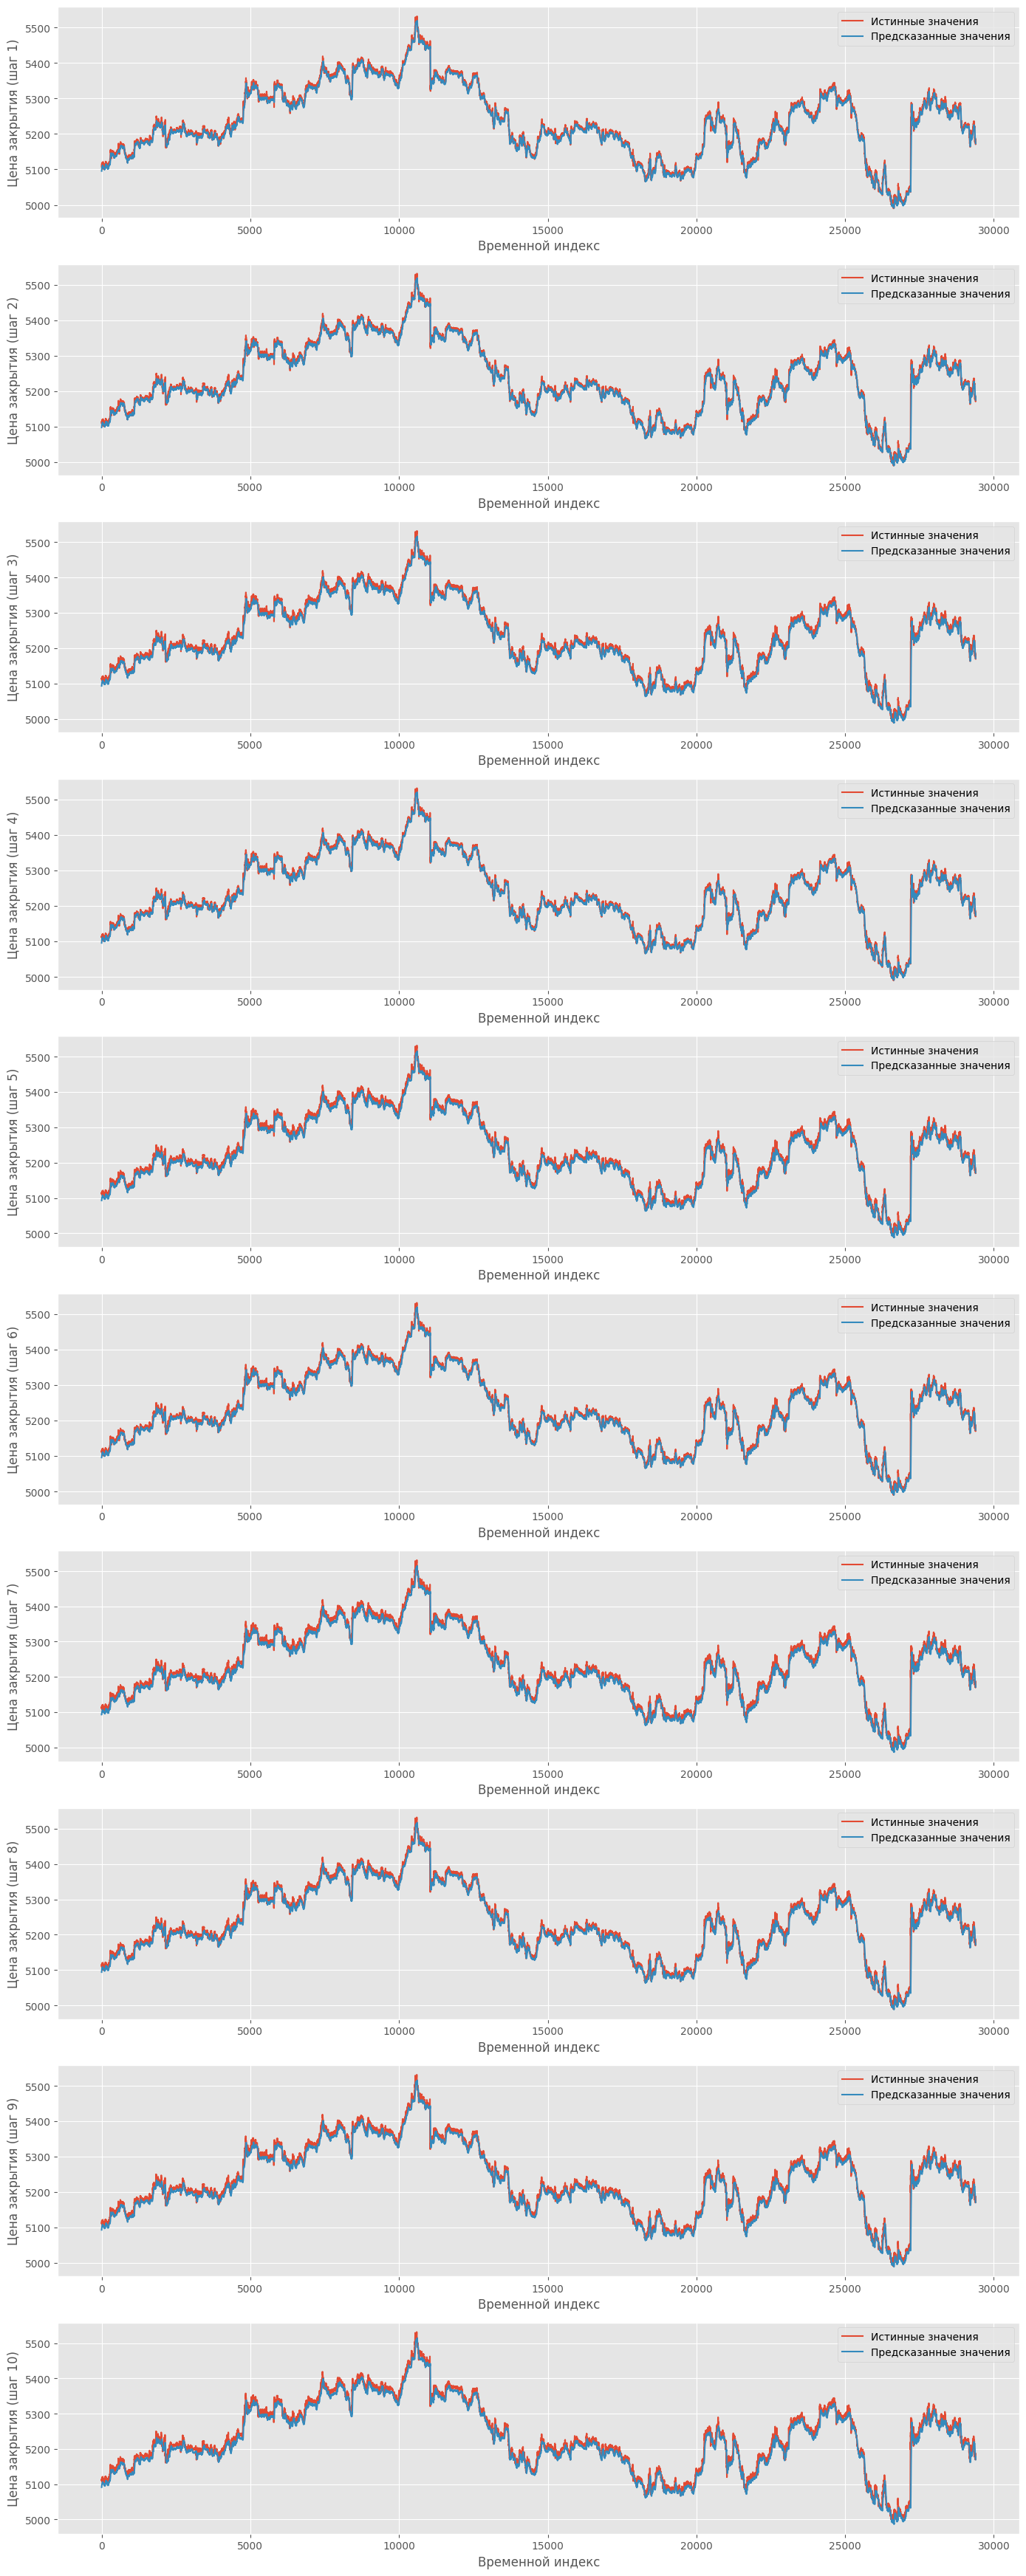

In [ ]:
# Преобразование временных рядов в данные для обучения на 10 шагов вперед
def create_dataset(dataset, time_step=1, steps_ahead=10):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-steps_ahead+1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step:i+time_step+steps_ahead, 0])
    return np.array(dataX), np.array(dataY)

# Создание новых наборов данных для обучения на 10 шагов вперед
X_train_multi, y_train_multi = create_dataset(xTrain, xLen, 10)
X_test_multi, y_test_multi = create_dataset(xTest, xLen, 10)

# Преобразование данных в формат, подходящий для обучения нейронной сети
X_train_multi = X_train_multi.reshape(X_train_multi.shape[0], X_train_multi.shape[1], 1)
X_test_multi = X_test_multi.reshape(X_test_multi.shape[0], X_test_multi.shape[1], 1)

# Создание модели для прогнозирования на 10 шагов вперед
model_multi = Sequential()
model_multi.add(Flatten(input_shape=(xLen, 1)))
model_multi.add(Dense(64, activation='relu'))
model_multi.add(Dense(10))  # 10 шагов вперед
model_multi.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели
model_multi.fit(X_train_multi, y_train_multi, validation_data=(X_test_multi, y_test_multi), epochs=10, batch_size=16, verbose=1)

# Предсказание на тестовой выборке
y_pred_multi = model_multi.predict(X_test_multi)

# Обратное преобразование данных
y_pred_multi = yScaler.inverse_transform(y_pred_multi)
y_test_multi = yScaler.inverse_transform(y_test_multi)

# Визуализация результатов
fig, axes = plt.subplots(10, 1, figsize=(14, 20))
for i in range(10):
    axes[i].plot(y_test_multi[:, i], label='Истинные значения')
    axes[i].plot(y_pred_multi[:, i], label='Предсказанные значения')
    axes[i].set_xlabel('Временной индекс')
    axes[i].set_ylabel(f'Цена закрытия (шаг {i+1})')
    axes[i].legend()

plt.tight_layout()
plt.show()


Создание и обучение модели Conv1D

Epoch 1/10
11728/11728 [==============================] - 131s 11ms/step - loss: 1.4287e-04 - val_loss: 2.5289e-05
Epoch 2/10
11728/11728 [==============================] - 123s 10ms/step - loss: 3.3935e-05 - val_loss: 3.7247e-05
Epoch 3/10
11728/11728 [==============================] - 119s 10ms/step - loss: 2.8253e-05 - val_loss: 2.5246e-05
Epoch 4/10
11728/11728 [==============================] - 121s 10ms/step - loss: 2.4103e-05 - val_loss: 7.7981e-05
Epoch 5/10
11728/11728 [==============================] - 118s 10ms/step - loss: 2.2523e-05 - val_loss: 2.0423e-04
Epoch 6/10
11728/11728 [==============================] - 121s 10ms/step - loss: 2.0564e-05 - val_loss: 1.3573e-05
Epoch 7/10
11728/11728 [==============================] - 115s 10ms/step - loss: 2.0092e-05 - val_loss: 4.4585e-05
Epoch 8/10
11728/11728 [==============================] - 124s 11ms/step - loss: 1.8781e-05 - val_loss: 2.1060e-05
Epoch 9/10
11728/11728 [==============================] - 116s 10ms/step - loss:

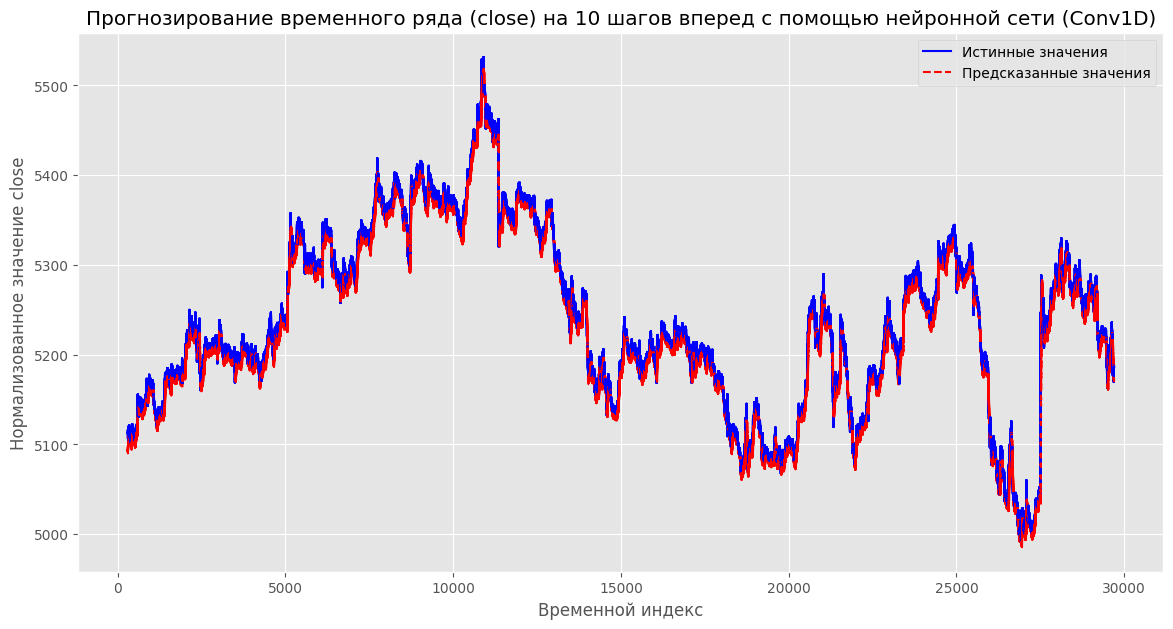

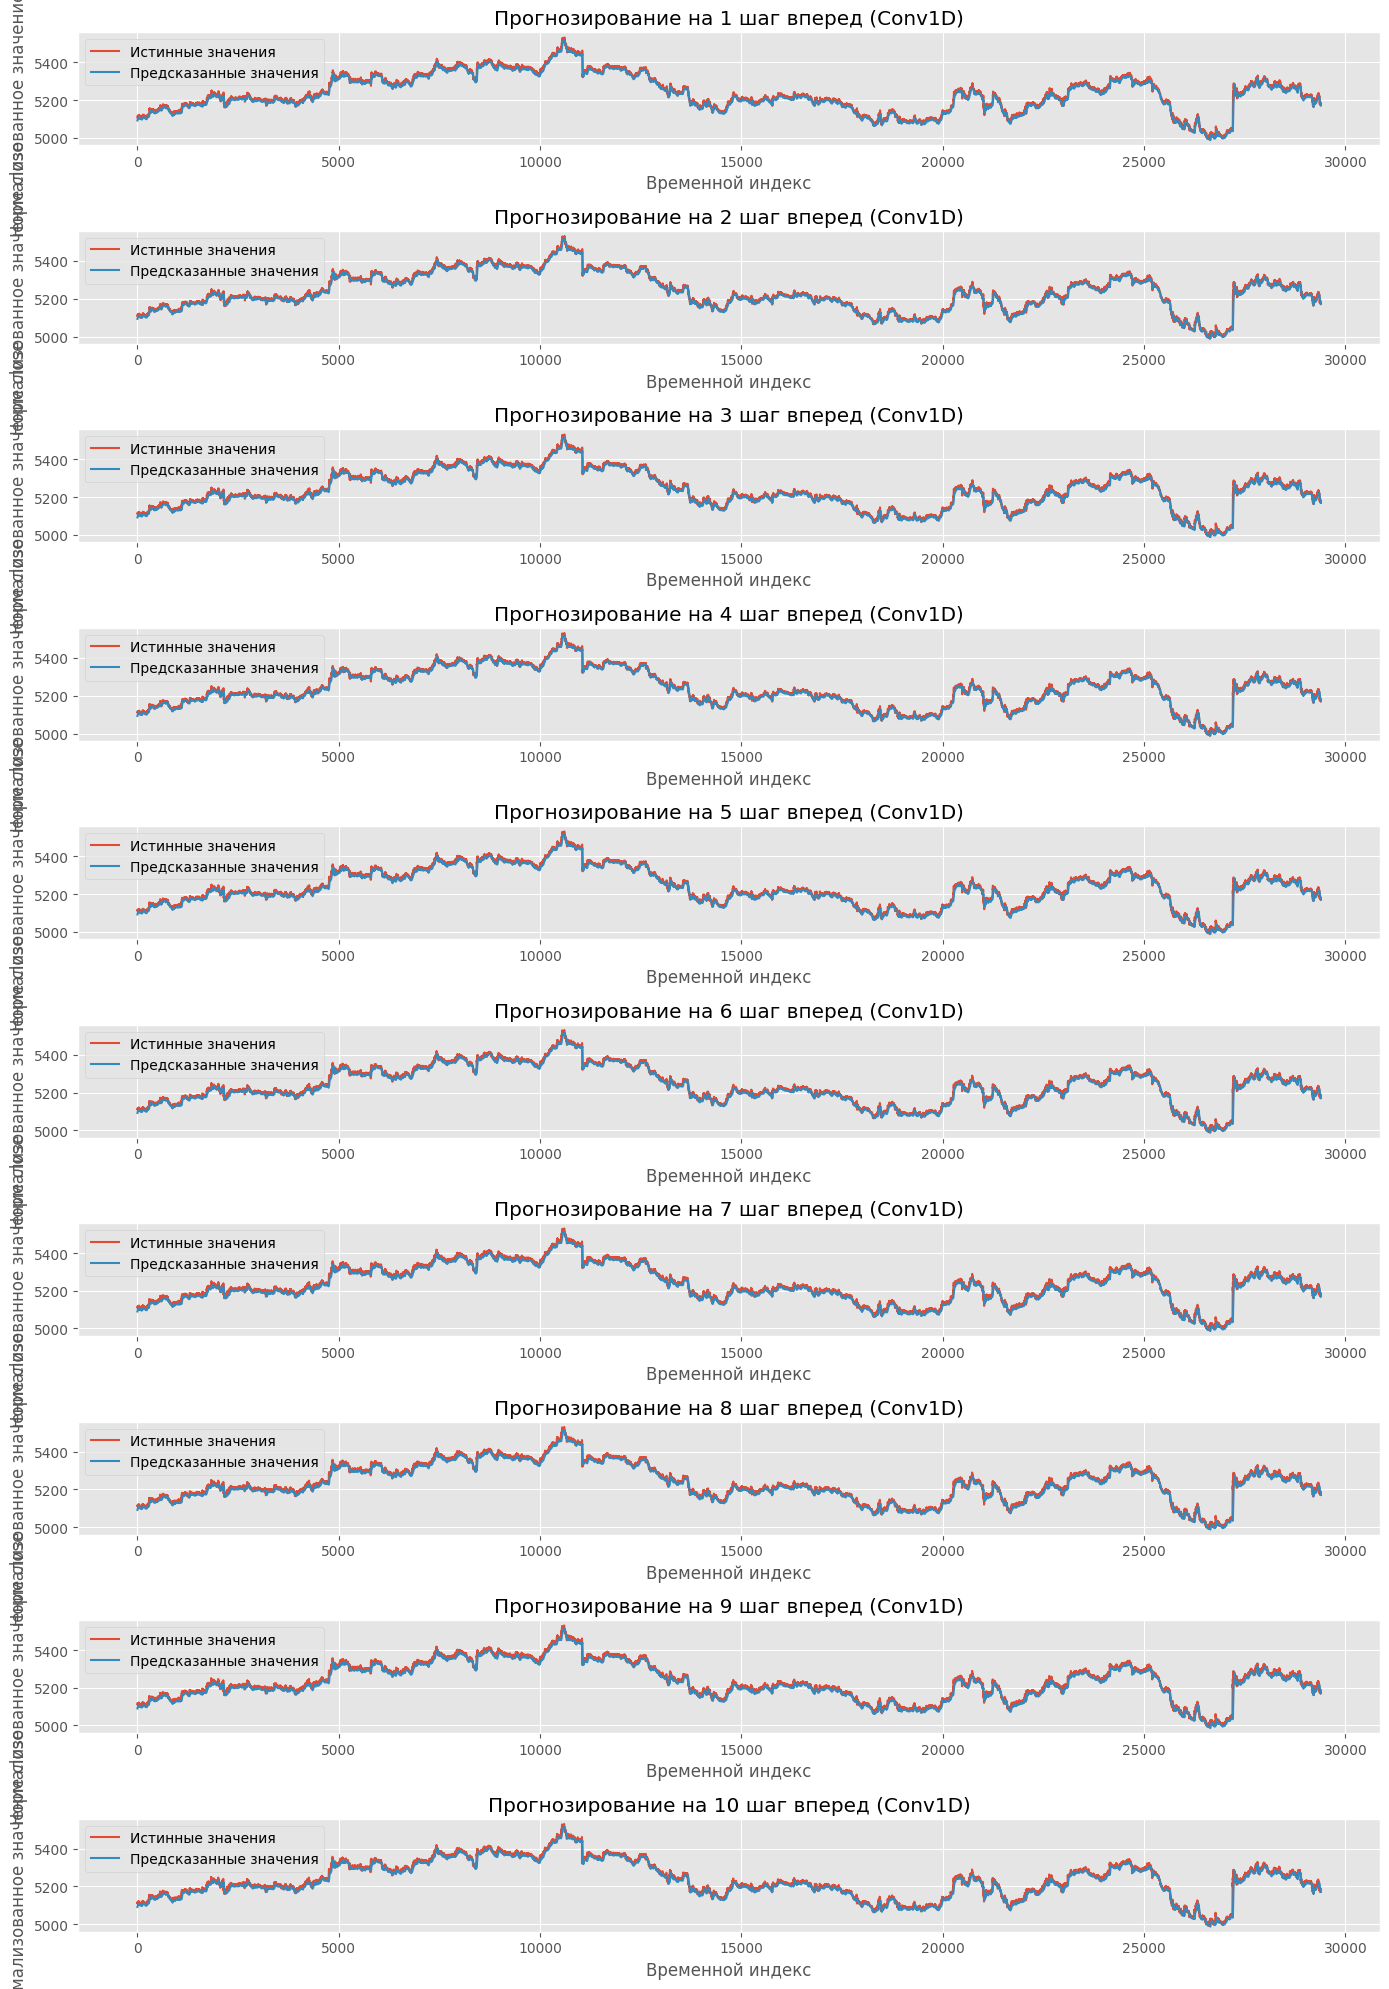

In [ ]:
from keras.layers import Conv1D, MaxPooling1D

# Преобразование временных рядов в данные для обучения на 10 шагов вперед
def create_dataset(dataset, time_step=1, steps_ahead=10):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - steps_ahead + 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step:i + time_step + steps_ahead, 0])
    return np.array(dataX), np.array(dataY)

# Создание новых наборов данных для обучения на 10 шагов вперед
X_train_multi, y_train_multi = create_dataset(xTrain, xLen, 10)
X_test_multi, y_test_multi = create_dataset(xTest, xLen, 10)

# Преобразование данных в формат, подходящий для обучения нейронной сети
X_train_multi = X_train_multi.reshape(X_train_multi.shape[0], X_train_multi.shape[1], 1)
X_test_multi = X_test_multi.reshape(X_test_multi.shape[0], X_test_multi.shape[1], 1)

# Создание модели с использованием слоев Conv1D
model_conv = Sequential()
model_conv.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(xLen, 1)))
model_conv.add(MaxPooling1D(pool_size=2))
model_conv.add(Flatten())
model_conv.add(Dense(64, activation='relu'))
model_conv.add(Dense(10))  # 10 шагов вперед
model_conv.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели
model_conv.fit(X_train_multi, y_train_multi, validation_data=(X_test_multi, y_test_multi), epochs=10, batch_size=16, verbose=1)

# Предсказание на тестовой выборке
y_pred_conv = model_conv.predict(X_test_multi)

# Обратное преобразование данных
y_pred_conv = yScaler.inverse_transform(y_pred_conv.reshape(-1, 1)).reshape(-1, 10)
y_test_multi = yScaler.inverse_transform(y_test_multi.reshape(-1, 1)).reshape(-1, 10)

# Визуализация результатов
plt.figure(figsize=(14, 7))
for i in range(len(y_test_multi)):
    plt.plot(range(i + xLen, i + xLen + 10), y_test_multi[i], color='b')
    plt.plot(range(i + xLen, i + xLen + 10), y_pred_conv[i], color='r', linestyle='dashed')

plt.xlabel('Временной индекс')
plt.ylabel('Нормализованное значение close')
plt.title('Прогнозирование временного ряда (close) на 10 шагов вперед с помощью нейронной сети (Conv1D)')
plt.legend(['Истинные значения', 'Предсказанные значения'])
plt.show()

# Визуализация результатов по всем 10 шагам предсказания
plt.figure(figsize=(14, 20))
for i in range(10):
    plt.subplot(10, 1, i + 1)
    plt.plot(y_test_multi[:, i], label='Истинные значения')
    plt.plot(y_pred_conv[:, i], label='Предсказанные значения')
    plt.xlabel('Временной индекс')
    plt.ylabel('Нормализованное значение close')
    plt.title(f'Прогнозирование на {i+1} шаг вперед (Conv1D)')
    plt.legend()

plt.tight_layout()
plt.show()
